# PINN NF2
> https://github.com/RobertJaro/NF2

## Low Lou Field

In [ ]:
import numpy as np

In [ ]:
from zpinn.lowloumag import LowLouMag

In [ ]:
b = LowLouMag(resolutions=[128, 64, 200])
b

### Low and Lou (1990) NLFFF
bounds = [-1, 1, -1, 1, 0, 2]<br>
resolutions = [128, 64, 200]<br>
n = 1<br>
m = 1<br>
l = 0.3<br>
Phi = 1.5707963267948966<br>


In [ ]:
b.calculate()

In [ ]:
b.grid

UniformGrid (0x7f9464c66f80)
  N Cells:      1592199
  N Points:     1638400
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   128, 64, 200
  Spacing:      1.575e-02, 3.175e-02, 1.005e-02
  N Arrays:     3

In [ ]:
Nx, Ny, _ =  b.grid.dimensions

In [ ]:
bottom_subset = (0, Nx-1, 0, Ny-1, 0, 0)
bottom_subset

(0, 127, 0, 63, 0, 0)

In [ ]:
bottom = b.grid.extract_subset(bottom_subset).extract_surface()
b_bottom = bottom['B'].reshape(Nx, Ny, 3)
b_bottom = np.array(b_bottom)
b_bottom.shape

(128, 64, 3)

In [ ]:
import matplotlib.pyplot as plt

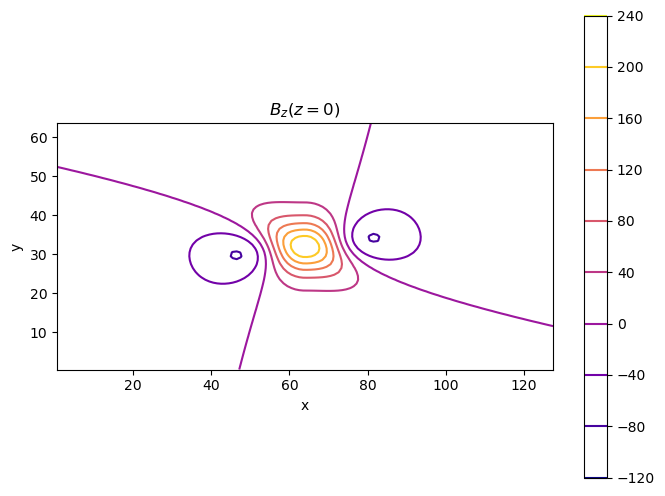

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contour(b_bottom[:, :, 2].transpose(), origin='lower', cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(r"$B_z(z=0)$")
ax.set_aspect('equal')
plt.colorbar()
plt.show()

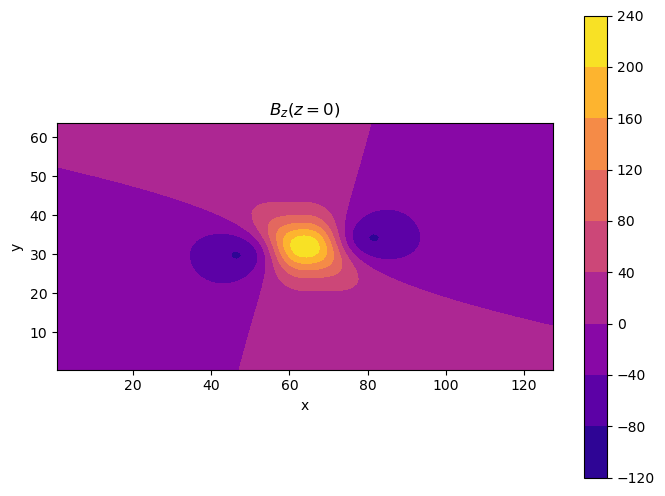

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contourf(b_bottom[:, :, 2].transpose(), origin='lower', cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(r"$B_z(z=0)$")
ax.set_aspect('equal')
plt.colorbar()
plt.show()

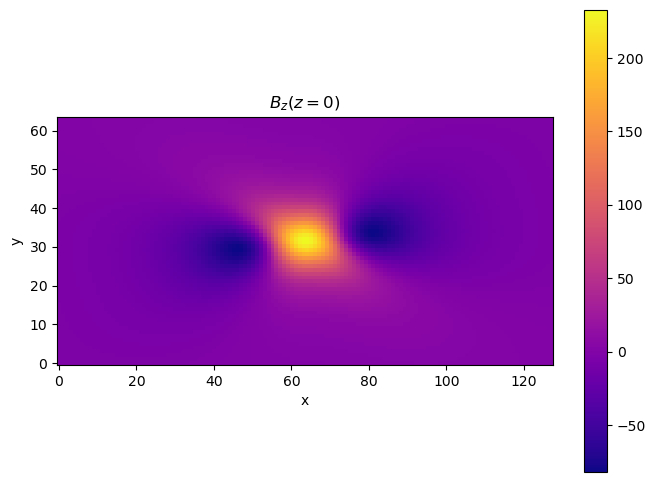

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(8,6))
plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='plasma')
plt.colorbar()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(r"$B_z(z=0)$")
plt.show()

## PINN

For given bottom boundary magnetic field (vector magnetogram) $\mathbf{B}(z=0)$,

we need to reconstrct the nonlinear force-free fields in the $z>0$ domain by solving following PDEs:

$$
(\nabla \times \mathbf{B}) \times \mathbf{B} = 0
$$

$$
\nabla \cdot \mathbf{B} = 0
$$

In [ ]:
type(b_bottom), b_bottom.shape

(numpy.ndarray, (128, 64, 3))

In [ ]:
# number of points along x
Nx, Ny, _ = b_bottom.shape
Nx, Ny

(128, 64)

In [ ]:
height = 200

In [ ]:
Nz = height
Nz

200

In [ ]:
Nx, Ny, Nz

(128, 64, 200)

In [ ]:
def create_coordinates(bounds):
    xbounds = (bounds[0], bounds[1])
    ybounds = (bounds[2], bounds[3])
    zbounds = (bounds[4], bounds[5])
    meshgrid = np.mgrid[xbounds[0]:xbounds[1]+1, ybounds[0]:ybounds[1]+1, zbounds[0]:zbounds[1]+1]
    return np.stack(meshgrid, axis=-1)

$z=0$

In [ ]:
bottom_bounds = (0, Nx-1, 0, Ny-1, 0, 0)
bottom_bounds 

(0, 127, 0, 63, 0, 0)

In [ ]:
bottom_values = b_bottom.reshape(-1, 3)
bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)
bottom_values.shape, bottom_coords.shape

((8192, 3), (8192, 3))

$z = N_z - 1$

In [ ]:
top_bounds = (0, Nx-1, 0, Ny-1, Nz-1, Nz-1)
top_bounds

(0, 127, 0, 63, 199, 199)

$x = 0$

In [ ]:
lateral_bounds_1 = (0, 0, 0, Ny-1, 0, Nz-1)
lateral_bounds_1

(0, 0, 0, 63, 0, 199)

$x = N_x - 1$

In [ ]:
lateral_bounds_2 = (Nx-1, Nx-1, 0, Ny-1, 0, Nz-1)
lateral_bounds_2

(127, 127, 0, 63, 0, 199)

$y = 0$

In [ ]:
lateral_bounds_3 = (0, Nx-1, 0, 0, 0, Nz-1)
lateral_bounds_3

(0, 127, 0, 0, 0, 199)

$y = N_y - 1$

In [ ]:
lateral_bounds_4 = (0, Nx-1, Ny-1, Ny-1, 0, Nz-1)
lateral_bounds_4

(0, 127, 63, 63, 0, 199)

In [ ]:
top_lateral_coordinates = [create_coordinates(top_bounds).reshape(-1, 3),
                      create_coordinates(lateral_bounds_1).reshape(-1, 3),
                      create_coordinates(lateral_bounds_2).reshape(-1, 3),
                      create_coordinates(lateral_bounds_3).reshape(-1, 3),
                      create_coordinates(lateral_bounds_4).reshape(-1, 3)]

top_lateral_coordinates[0].shape, top_lateral_coordinates[1].shape, top_lateral_coordinates[2].shape, top_lateral_coordinates[3].shape, top_lateral_coordinates[4].shape

((8192, 3), (12800, 3), (12800, 3), (25600, 3), (25600, 3))

## Green's function method -> Potential field

In [ ]:
import os

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from tqdm import tqdm

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class PotentialModel(nn.Module):

    def __init__(self, b_n, r_p):
        super().__init__()
        self.register_buffer('b_n', b_n)
        self.register_buffer('r_p', r_p)
        c = np.array([[0, 0, 1/np.sqrt(2*np.pi)]])
        c = torch.tensor(c, dtype=torch.float64)
        self.register_buffer('c', c)

    def forward(self, r):
        numerator = self.b_n[:, None]
        denominator = torch.sqrt(torch.sum((r[None, :] - self.r_p[:, None] + self.c[None])**2, -1))
        potential = torch.sum(numerator/denominator, 0) / (2*np.pi)
        return potential

In [ ]:
b_n = torch.tensor(bottom_values[:, 2])
r_p = torch.tensor(bottom_coords)

b_n.shape, r_p.shape

(torch.Size([8192]), torch.Size([8192, 3]))

In [ ]:
from torchinfo import summary

In [ ]:
potential_model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)
summary(potential_model)

Layer (type:depth-idx)                   Param #
DataParallel                             --
├─PotentialModel: 1-1                    --
Total params: 0
Trainable params: 0
Non-trainable params: 0

In [ ]:
pf_fields = []
pf_coords = []
for r_coords in top_lateral_coordinates:
    r_coords = torch.tensor(r_coords, dtype=torch.float64)
    pf_batch_size = int(np.prod(r_coords.shape[:-1]) // 10)

    fields = []
    for r, in tqdm(DataLoader(TensorDataset(r_coords), batch_size=pf_batch_size, num_workers=2),
                        desc='Potential Boundary'):
        r = r.to(device).requires_grad_(True)
        p_batch = potential_model(r)
        b_p = -1 * torch.autograd.grad(p_batch, r, torch.ones_like(p_batch), retain_graph=True, create_graph=True)[0]
        fields += [b_p.clone().detach().cpu().numpy()]
    pf_fields += [np.concatenate(fields)]
    pf_coords += [r_coords.clone().detach().cpu().numpy()]
top_lateral_values = np.concatenate(pf_fields) 
top_lateral_coords = np.concatenate(pf_coords)

Potential Boundary: 100%|█████████████| 10/10 [00:00<00:00, 21.47it/s]


In [ ]:
bottom_values.shape, bottom_coords.shape

((8192, 3), (8192, 3))

In [ ]:
top_lateral_values.shape, top_lateral_coords.shape

((84992, 3), (84992, 3))

In [ ]:
boundary_values = np.concatenate([top_lateral_values, bottom_values])
boundary_coords = np.concatenate([top_lateral_coords, bottom_coords])

boundary_values.shape, boundary_coords.shape

((93184, 3), (93184, 3))

In [ ]:
np.max(boundary_values), np.min(boundary_values)

(232.68615366993404, -142.50693526239803)

In [ ]:
boundary_values_abs_max = np.max([np.abs(np.max(boundary_values)), np.abs(np.min(boundary_values))])
boundary_values_abs_max

232.68615366993404

In [ ]:
np.max(boundary_coords), np.min(boundary_coords)

(199.0, 0.0)

In [ ]:
boundary_coords_max = np.max(boundary_coords)
boundary_coords_max

199.0

In [ ]:
b_norm = int(boundary_values_abs_max)
spatial_norm = int(boundary_coords_max)

b_norm, spatial_norm

(232, 199)

In [ ]:
normalized_boundary_values = boundary_values / b_norm
normalized_boundary_coords = boundary_coords / spatial_norm

In [ ]:
np.max(normalized_boundary_values), np.min(normalized_boundary_values)

(1.0029575589221296, -0.6142540313034398)

In [ ]:
np.max(normalized_boundary_coords), np.min(normalized_boundary_coords)

(1.0, 0.0)

In [ ]:
boundary_data = np.stack([normalized_boundary_coords, normalized_boundary_values], 1)
boundary_data[0], boundary_data.shape

(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [-5.50607878e-05, -2.31669594e-05,  1.17348712e-04]]),
 (93184, 2, 3))

In [ ]:
class BModel(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_neurons, num_layers):
        super().__init__()
        self.d_in = nn.Linear(num_inputs, num_neurons).double()
        lin = [nn.Linear(num_neurons, num_neurons).double() for _ in range(num_layers)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(num_neurons, num_outputs).double()
        self.activation = torch.sin

    def forward(self, x):
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        B = self.d_out(x)
        return B

In [ ]:
num_inputs = 3
num_outputs = 3
num_neurons = 256
num_layers = 8

In [ ]:
Bmodel = nn.DataParallel(BModel(num_inputs, num_outputs, num_neurons, num_layers)).to(device)
summary(Bmodel)

Layer (type:depth-idx)                   Param #
DataParallel                             --
├─BModel: 1-1                            --
│    └─Linear: 2-1                       1,024
│    └─ModuleList: 2-2                   --
│    │    └─Linear: 3-1                  65,792
│    │    └─Linear: 3-2                  65,792
│    │    └─Linear: 3-3                  65,792
│    │    └─Linear: 3-4                  65,792
│    │    └─Linear: 3-5                  65,792
│    │    └─Linear: 3-6                  65,792
│    │    └─Linear: 3-7                  65,792
│    │    └─Linear: 3-8                  65,792
│    └─Linear: 2-3                       771
Total params: 528,131
Trainable params: 528,131
Non-trainable params: 0

In [ ]:
learning_rate = 5e-4

In [ ]:
opt = torch.optim.Adam(Bmodel.parameters(), lr=learning_rate)
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)

Weights

$$
\mathcal{L}_f(\boldsymbol{\theta}; \mathcal{T}_f) = w_{\text{ff}}\mathcal{L}_\text{ff}(\boldsymbol{\theta}; \mathcal{T}_f) + w_{\text{div}}\mathcal{L}_\text{div}(\boldsymbol{\theta}; \mathcal{T}_f)
$$

$$
\mathcal{L}_\text{ff}(\boldsymbol{\theta}; \mathcal{T}_f) = \frac{1}{|\mathcal{T}_f|} \sum_{\boldsymbol{x}\in \mathcal{T}_f} \frac{|(\nabla \times \mathbf{\hat{B}})\times \mathbf{\hat{B}}|^2}{|\mathbf{\hat{B}}|^2}
$$

$$
\mathcal{L}_\text{div}(\boldsymbol{\theta}; \mathcal{T}_f) = \frac{1}{|\mathcal{T}_f|} \sum_{\boldsymbol{x}\in \mathcal{T}_f} |\nabla \cdot \mathbf{\hat{B}}|^2
$$

$$
\mathcal{L}_\text{bc}(\boldsymbol{\theta};\mathcal{T}_b)=\frac{1}{|\mathcal{T}_b|}\sum_{\boldsymbol{x}\in\mathcal{T}_b}{|\mathbf{\hat{B}}-\mathbf{B}|^2}
$$

$$
\mathcal{L} = w_{\text{ff}}\mathcal{L}_\text{ff} + w_{\text{div}}\mathcal{L}_\text{div} +  w_{\text{bc}}\mathcal{L}_{\text{bc}}
$$

In [ ]:
total_iterations = 50000
decay_iterations = 25000

In [ ]:
w_ff = 1
w_div = 1
w_bc = 1000
w_bc_decay = (1/1000)**(1/decay_iterations)

Collocation points

In [ ]:
collocation_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)

In [ ]:
collocation_coords = create_coordinates(collocation_bounds).reshape(-1, 3)
normalized_collocation_coords = collocation_coords / spatial_norm
normalized_collocation_coords = torch.tensor(normalized_collocation_coords)

normalized_collocation_coords.shape

torch.Size([1638400, 3])

In [ ]:
np.max(collocation_coords), np.min(collocation_coords)

(199, 0)

In [ ]:
torch.max(normalized_collocation_coords), torch.min(normalized_collocation_coords)

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
scheduler = ExponentialLR(opt, gamma=(1/10)**(1 / total_iterations))
scheduler

<torch.optim.lr_scheduler.ExponentialLR>

DataLoader

In [ ]:
# Shuffle data
shuffle_idx = np.random.permutation(boundary_data.shape[0])
shuffle_boundary_data = boundary_data[shuffle_idx]
shuffle_boundary_data.shape, boundary_data.shape

((93184, 2, 3), (93184, 2, 3))

In [ ]:
shuffle_boundary_data[0], boundary_data[shuffle_idx[0]]

(array([[ 0.32663317,  0.        ,  0.06532663],
        [-0.00496271, -0.01981037,  0.01258576]]),
 array([[ 0.32663317,  0.        ,  0.06532663],
        [-0.00496271, -0.01981037,  0.01258576]]))

In [ ]:
batch_size = 10000

In [ ]:
# adjust to batch size
pad = batch_size - shuffle_boundary_data.shape[0] % batch_size
shuffle_boundary_data = np.concatenate([shuffle_boundary_data, shuffle_boundary_data[:pad]])
pad, shuffle_boundary_data.shape

(6816, (100000, 2, 3))

In [ ]:
# split data into batches
n_batches = shuffle_boundary_data.shape[0] // batch_size
batches = np.array(np.split(shuffle_boundary_data, n_batches))
batches.shape

(10, 10000, 2, 3)

First batch [coord, field] pair

In [ ]:
batches[0].shape, batches[0]

((10000, 2, 3),
 array([[[ 3.26633166e-01,  0.00000000e+00,  6.53266332e-02],
         [-4.96270764e-03, -1.98103717e-02,  1.25857646e-02]],
 
        [[ 6.38190955e-01,  1.10552764e-01,  1.50753769e-01],
         [ 6.81800003e-04,  2.11255737e-03, -2.44731131e-03]],
 
        [[ 4.57286432e-01,  3.51758794e-02,  0.00000000e+00],
         [ 2.76822153e-02,  3.10457626e-03,  2.43337901e-02]],
 
        ...,
 
        [[ 6.38190955e-01,  1.50753769e-01,  3.16582915e-01],
         [ 9.20926854e-04,  3.44235955e-04, -2.19595953e-04]],
 
        [[ 4.82412060e-01,  1.70854271e-01,  1.00000000e+00],
         [ 3.40915106e-05,  4.94375624e-06,  1.49043171e-04]],
 
        [[ 1.00502513e-02,  3.16582915e-01,  4.47236181e-01],
         [-4.92748140e-04,  1.57136314e-05,  3.50397773e-04]]]))

Only coord -> [:, 0, :]

In [ ]:
batches[0][:,0,:].shape, batches[0][:,0,:]

((10000, 3),
 array([[0.32663317, 0.        , 0.06532663],
        [0.63819095, 0.11055276, 0.15075377],
        [0.45728643, 0.03517588, 0.        ],
        ...,
        [0.63819095, 0.15075377, 0.31658291],
        [0.48241206, 0.17085427, 1.        ],
        [0.01005025, 0.31658291, 0.44723618]]))

Only field -> [:, 1, :]

In [ ]:
batches[0][:,1,:].shape, batches[0][:,1,:]

((10000, 3),
 array([[-4.96270764e-03, -1.98103717e-02,  1.25857646e-02],
        [ 6.81800003e-04,  2.11255737e-03, -2.44731131e-03],
        [ 2.76822153e-02,  3.10457626e-03,  2.43337901e-02],
        ...,
        [ 9.20926854e-04,  3.44235955e-04, -2.19595953e-04],
        [ 3.40915106e-05,  4.94375624e-06,  1.49043171e-04],
        [-4.92748140e-04,  1.57136314e-05,  3.50397773e-04]]))

In [ ]:
batches_path = 'batches.npy'

In [ ]:
np.save(batches_path, batches)

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class BoundaryDataset(Dataset):

    def __init__(self, batches_path):
        self.batches_path = batches_path

    def __len__(self):
        return np.load(self.batches_path, mmap_mode='r').shape[0]

    def __getitem__(self, idx):
        # lazy load data
        d = np.load(self.batches_path, mmap_mode='r')[idx]
        d = np.copy(d)
        coord, field = d[:, 0],  d[:, 1]
        return coord, field

In [ ]:
dataset = BoundaryDataset(batches_path)

In [ ]:
from torch.utils.data import RandomSampler

In [ ]:
data_loader = DataLoader(dataset, batch_size=None, num_workers=2, pin_memory=True,
                        sampler=RandomSampler(dataset, replacement=True, num_samples=total_iterations))

In [ ]:
from datetime import datetime

In [ ]:
Bmodel.train()

for iter, (boundary_coords, boundary_b) in tqdm(enumerate(data_loader, start=0),
                                                total=len(data_loader), desc='Training'):
    start_time = datetime.now()
    boundary_coords, boundary_b= boundary_coords.to(device), boundary_b.to(device)

    boundary_B = Bmodel(boundary_coords)                                                
    loss_bc = torch.mean(torch.sum((boundary_B - boundary_b)**2, dim=-1))

    perm = torch.randperm(normalized_collocation_coords.shape[0])
    idx = perm[:batch_size]
    co_coords = normalized_collocation_coords[idx].to(device)
    co_coords.requires_grad = True

    r = co_coords
    B = Bmodel(r)
    dBx_dr = torch.autograd.grad(B[:, 0], r, torch.ones_like(B[:, 0]), retain_graph=True, create_graph=True)[0]
    dBy_dr = torch.autograd.grad(B[:, 1], r, torch.ones_like(B[:, 1]), retain_graph=True, create_graph=True)[0]
    dBz_dr = torch.autograd.grad(B[:, 2], r, torch.ones_like(B[:, 2]), retain_graph=True, create_graph=True)[0]

    dBx_dx = dBx_dr[:, 0]
    dBx_dy = dBx_dr[:, 1]
    dBx_dz = dBx_dr[:, 2]

    dBy_dx = dBy_dr[:, 0]
    dBy_dy = dBy_dr[:, 1]
    dBy_dz = dBy_dr[:, 2]

    dBz_dx = dBz_dr[:, 0]
    dBz_dy = dBz_dr[:, 1]
    dBz_dz = dBz_dr[:, 2]

    rot_x = dBz_dy - dBy_dz
    rot_y = dBx_dz - dBz_dx
    rot_z = dBy_dx - dBx_dy

    J = torch.stack([rot_x, rot_y, rot_z], -1)
    JxB = torch.cross(J, B, dim=-1)

    divB = dBx_dx + dBy_dy + dBz_dz

    loss_ff = torch.mean(torch.sum(JxB**2, dim=-1) / (torch.sum(B**2, dim=-1) + 1e-7))
    loss_div = torch.mean(torch.sum((divB)**2, dim=-1))

    loss = w_bc*loss_bc + w_ff*loss_ff + w_div*loss_div

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(Bmodel.parameters(), 0.1)
    opt.step()

    if w_bc > 1:
        w_bc *=w_bc_decay
        if w_bc <= 1:
            w_bc = 1
    if scheduler.get_last_lr()[0] > 5e-5:
        scheduler.step()
                                                    
    if (iter + 1) % 1000 == 0:
        print('[Iteration %06d/%06d] [loss: %.08f] [loss_bc: %.08f; div_loss: %.08f; ff_loss: %.08f] [w_bc: %f, lr: %f] [%s]' %
                (iter + 1, total_iterations,
                loss,
                w_bc*loss_bc,
                w_ff*loss_ff,
                w_div*loss_div,
                w_bc,
                scheduler.get_last_lr()[0],
                datetime.now() - start_time))

Training:   0%|▏                                                                                                                                                                                                          | 32/50000 [00:06<2:51:52,  4.85it/s]


KeyboardInterrupt: 

In [ ]:
cube_shape = (Nx, Ny, Nz)
cube_shape

In [ ]:
torch.save({'model': Bmodel,
            'cube_shape': cube_shape,
            'b_norm': b_norm,
            'spatial_norm': spatial_norm,
            'm': model.state_dict(),
            'o': opt.state_dict()}, 
            os.path.join(base_path, 'fields_%06d.nf2' % iter))

In [ ]:
torch.save({'loss_bc': loss_bc.detach().cpu().numpy(),
            'w_bc': w_bc,
            'loss_div': loss_div.detach().cpu().numpy(),
            'w_div': w_div,
            'loss_ff': loss_ff.detach().cpu().numpy(),
            'w_ff': w_ff,
            'lr':scheduler.get_last_lr()[0]}, 
            'model_parameter.pt')